In [ ]:
%load_ext autoreload
%autoreload 2
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import datasets
import numpy as np
import os.path
from spacy.lang.en import English
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import dvu
dvu.set_style()
import pandas as pd
from os.path import join as oj
import data
import matplotlib.pyplot as plt
import seaborn as sns
import config
pd.set_option('display.max_rows', None)

Compute embeddings for sst2 using bert finetuned model.

In [ ]:
class A:
    checkpoint = 'textattack/bert-base-uncased-SST-2'
    dataset = 'sst2'
    padding = True
args = A()

# data
dataset, args = data.process_data_and_args(args)

# countvectorizer
tok_simp = English().tokenizer
tokenizer_func = lambda x: [str(x) for x in tok_simp(x)] 
v = CountVectorizer(tokenizer=tokenizer_func)
v.fit(dataset['train']['sentence'])
vocab = v.vocabulary_
words = sorted(list(vocab.keys()))

# compute embeddings

In [39]:
# set up model
tokenizer = AutoTokenizer.from_pretrained(args.checkpoint) # for actually passing things to the model
model = BertModel.from_pretrained(args.checkpoint)

tokens = tokenizer(words, padding=args.padding, truncation=True, return_tensors="pt")
output = model(**tokens) # this takes a while....
embs = output['pooler_output'].cpu().detach().numpy()
pkl.dump(embs, open(oj(config.misc_dir, 'word_embs_sst_train.pkl'), 'wb'))
pkl.dump(words, open(oj(config.misc_dir, 'word_list_sst_train.pkl'), 'wb'))

# look at embeddings

In [2]:
embs = pkl.load(open(oj(config.misc_dir, 'word_embs_sst_train.pkl'), 'rb'))
words = pkl.load(open(oj(config.misc_dir, 'word_list_sst_train.pkl'), 'rb'))

In [5]:
matrix = v.transform(dataset['train']['sentence'])
counts = pd.DataFrame(matrix.toarray(), columns=v.get_feature_names())
tot_counts = counts.sum()
sims = embs @ embs.T

In [ ]:
sns.heatmap(sims)

In [ ]:
sns.clustermap(sims)

In [10]:
sims.shape

(13887, 13887)

In [ ]:
tot_counts_top = tot_counts.sort_values(ascending=False)

In [ ]:
tot_counts.sort_values(ascending=False)

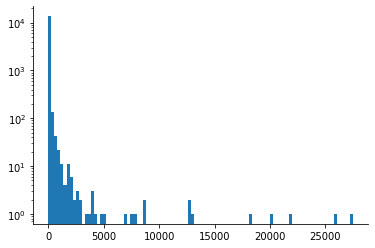

In [18]:
plt.hist(tot_counts, bins=100)
plt.yscale('log')

In [ ]:
np.unique(tot_counts, return_counts=True)